In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pathlib import Path
import itertools
import numpy as np
import json
import math
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [2]:
config ={
    "DATASET_PATH": "dataset",
    "CLASS_NAMES": ["Red Spot", "Brown Petal", "Red Petal + Yellow Spots"]
}
all_metadata = json.loads(
    Path('dataset/metadata.json').read_text()
)
vs_concept = np.loadtxt('dataset/vectors_concept_vector.vec.txt')
vs_context = np.loadtxt('dataset/vectors_context_vector.vec.txt')
all_classes = [m['class_id'] for m in all_metadata]
distinct_classes = sorted(set(all_classes))
vs_concept_distances = pairwise_distances(vs_concept, metric='cosine')
vs_context_distances = pairwise_distances(vs_context, metric='cosine')

In [3]:
print(len(distinct_classes))
print(len(all_classes))
print(len(all_metadata))
print(vs_concept.shape)
print(vs_context.shape)
print(vs_concept_distances.shape)
print(vs_context_distances.shape)

3
3000
3000
(3000, 9)
(3000, 21)
(3000, 3000)
(3000, 3000)


In [4]:
all_classes = [m['class_id'] for m in all_metadata]

In [5]:
def generate_pedagogic_pairs(criteria, alpha=0.5, beta=0.5, output_dir=None, anonymize_class=False):
    class_names = config['CLASS_NAMES']
    if anonymize_class:
        class_names = ["A", "B", "C"]
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    for c1, c2 in itertools.combinations(distinct_classes, r=2):
        c1_item_ixes = [ix for ix, c in enumerate(all_classes) if c==c1]
        c2_item_ixes = [ix for ix, c in enumerate(all_classes) if c==c2]
        pairs = list(itertools.product(c1_item_ixes, c2_item_ixes))
        if criteria == 'good':
            pair_scores = [
                alpha * vs_concept_distances[pair[0], pair[1]]
                - beta  * vs_context_distances[pair[0], pair[1]]
                # + 0.125 * classifier_confidences[pair[0]]
                # + 0.125 * classifier_confidences[pair[1]]
                for pair in pairs
            ]
            
        elif criteria == 'random':
            pair_scores = np.random.rand(len(pairs))
        else:
            raise ValueError("Unknown criteria: " + criteria)
        
        print(f"------------- {class_names[c1]} V.S. {class_names[c2]} -------------")
        for rank, pair_ix in enumerate((np.argsort(pair_scores)[::-1])[:3]):
            pair = pairs[pair_ix]
            score = pair_scores[pair_ix]
            print(f"Rank: {rank+1}. Score: {score}")
            plt.figure()
            for i in range(2):
                plt.subplot(1,2,i+1)
                img = plt.imread(
                    Path(config['DATASET_PATH']) / f"{all_metadata[pair[i]]['id']}.png"
                )
                plt.imshow(img)
                class_id = all_metadata[pair[i]]['class_id']
                # print(all_metadata[pair[i]])
                plt.title(f"class# {class_names[class_id]}")
            if output_dir:
                output_file = Path(output_dir) / f'{c1}_vs_{c2}_{rank}.png'
                plt.savefig(output_file)
            plt.show()


# Part 1: Examples of Random Contrasts

------------- A V.S. B -------------
Rank: 1. Score: 0.9999997549360157


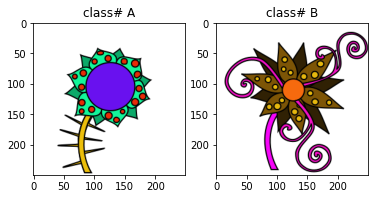

Rank: 2. Score: 0.999999651913385


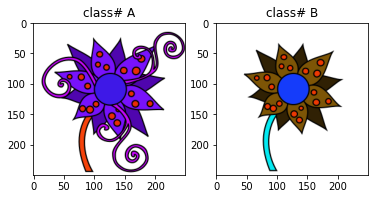

Rank: 3. Score: 0.999998135553738


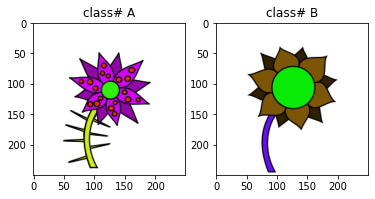

------------- A V.S. C -------------
Rank: 1. Score: 0.9999986514712494


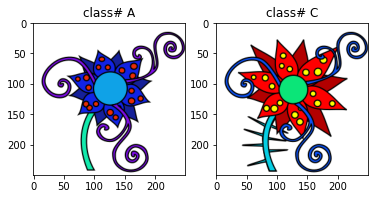

Rank: 2. Score: 0.9999979864903609


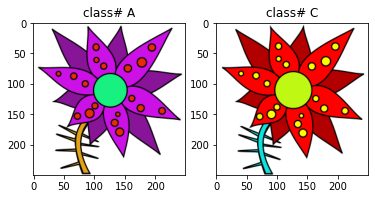

Rank: 3. Score: 0.9999976782418598


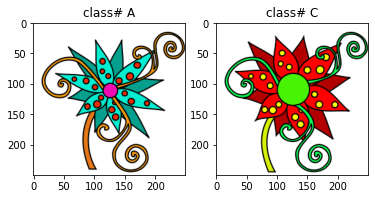

------------- B V.S. C -------------
Rank: 1. Score: 0.9999991750657931


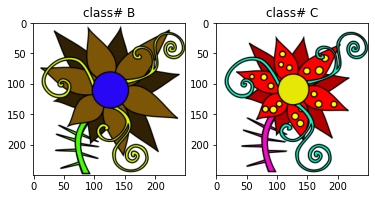

Rank: 2. Score: 0.9999989644529435


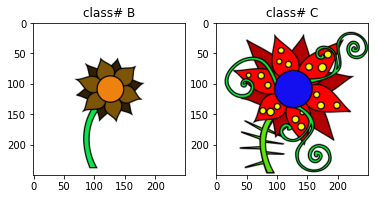

Rank: 3. Score: 0.9999978764079158


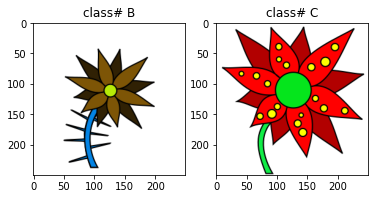

In [6]:
generate_pedagogic_pairs("random", output_dir="experiment_200_data/control", anonymize_class=True)

# Part 2: Examples of Good Contrasts

$$
score(x^{(i)}, x^{(j)}) =
\alpha D_d(x^{(i)}, x^{(j)}) - \beta D_c(x^{(i)}, x^{(j)}) \\
\\
\alpha \text{: weight of Dimilarity in relevant features}
\\
\beta \text{: weight of Similarity in irrelevant features}
$$

In [7]:
def find_contrasts(alpha, beta):
    print("################################################")
    print("# CONTRASTING CASES WITH PARAMETERS:           #")
    print(f'# 𝛼:{alpha:+.1f} 𝛽:{beta:+.1f}                                #')
    print("################################################")
    generate_pedagogic_pairs("good", alpha, beta)
    

interact(
    find_contrasts, 
    alpha=widgets.FloatSlider(min=-1., max=1., step=0.1, value=0.5, description='𝛼'), 
    beta=widgets.FloatSlider(min=-1., max=1., step=0.1, value=0.5, description='𝛽')
);

interactive(children=(FloatSlider(value=0.5, description='𝛼', max=1.0, min=-1.0), FloatSlider(value=0.5, descr…

------------- A V.S. B -------------
Rank: 1. Score: 0.06940755469224857


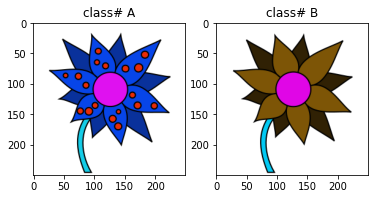

Rank: 2. Score: 0.06755643011500571


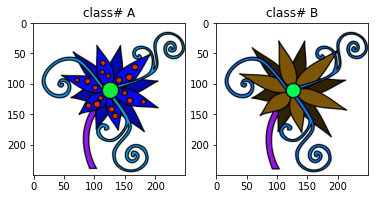

Rank: 3. Score: 0.06669483571492112


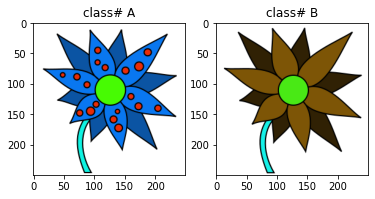

------------- A V.S. C -------------
Rank: 1. Score: 0.025621734328018553


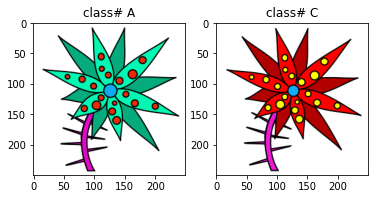

Rank: 2. Score: 0.023603905205101507


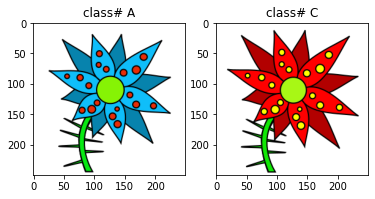

Rank: 3. Score: 0.023588620033265086


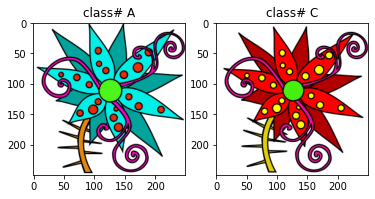

------------- B V.S. C -------------
Rank: 1. Score: 0.04107818041633737


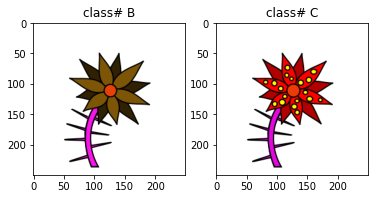

Rank: 2. Score: 0.040886334420045634


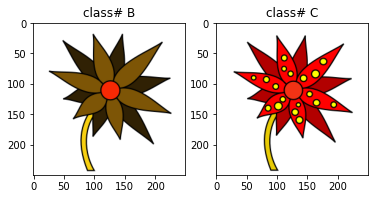

Rank: 3. Score: 0.040866291580802905


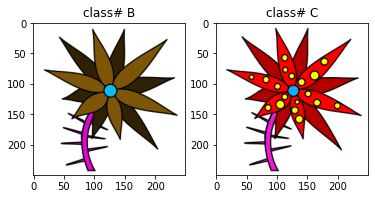

In [8]:
generate_pedagogic_pairs(
    "good", 
    alpha=0.1, 
    beta=1., 
    output_dir="experiment_200_data/treatment", 
    anonymize_class=True
)

# Part 3: Interpretation of $\alpha$ and $\beta$

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 0.7961579440915004


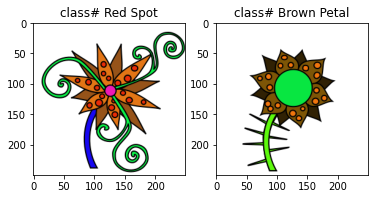

Rank: 2. Score: 0.7922533132321791


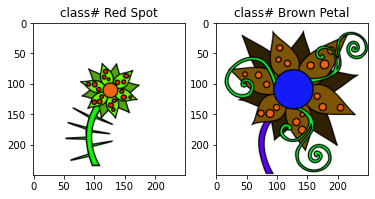

Rank: 3. Score: 0.7820778372158295


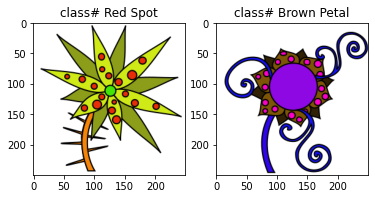

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.764173903754437


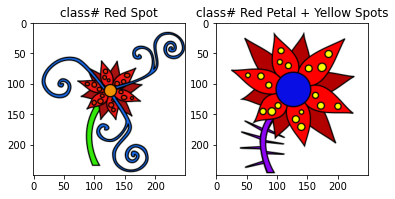

Rank: 2. Score: 0.7639134253632025


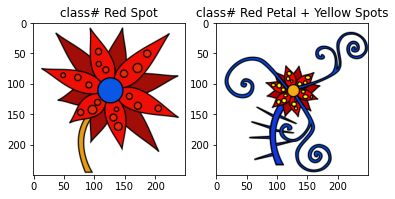

Rank: 3. Score: 0.7632768873498929


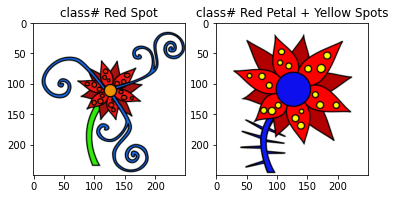

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.8105934346448297


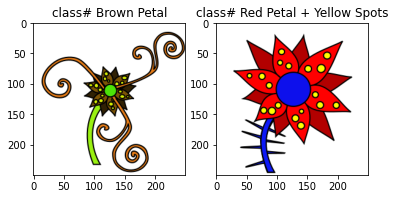

Rank: 2. Score: 0.8075665981472079


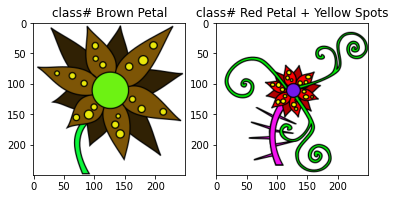

Rank: 3. Score: 0.8022527883692816


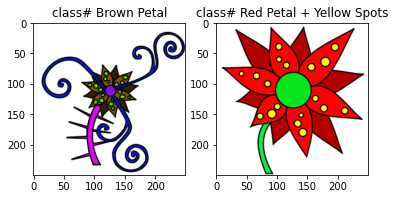

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: -0.016343793395937167


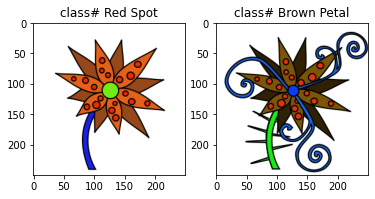

Rank: 2. Score: -0.01645094842032735


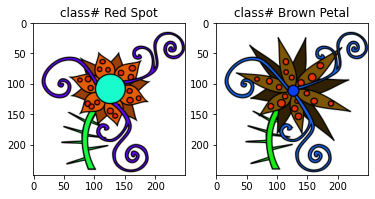

Rank: 3. Score: -0.01647258554708786


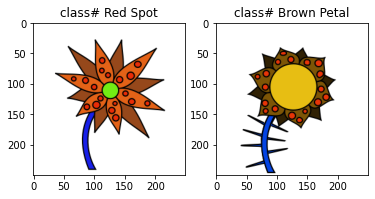

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.05849296384597824


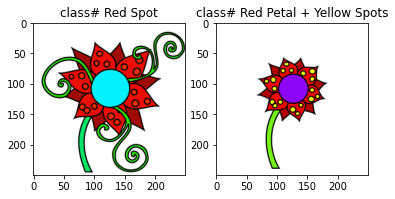

Rank: 2. Score: -0.05849296384597824


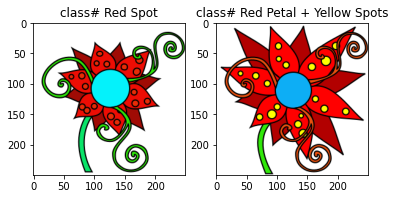

Rank: 3. Score: -0.05849296384597824


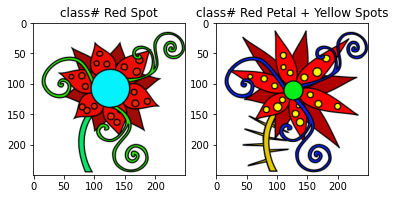

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.03091046054891411


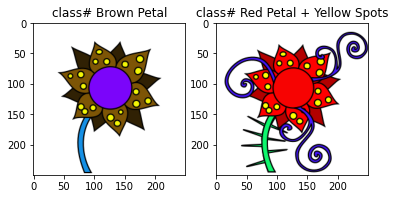

Rank: 2. Score: -0.03091046054891411


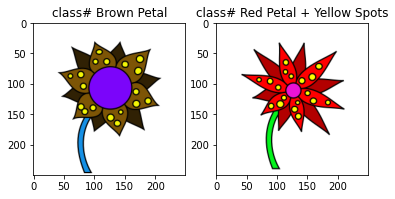

Rank: 3. Score: -0.03091046054891411


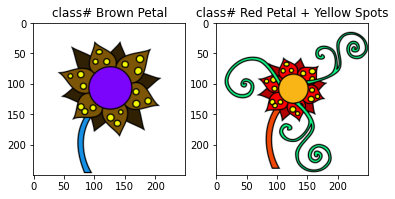

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: -0.025630145051510844


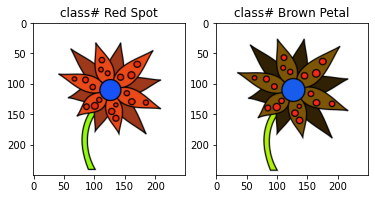

Rank: 2. Score: -0.03219607241321232


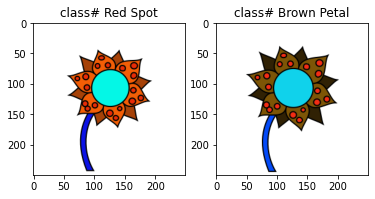

Rank: 3. Score: -0.040753377541237534


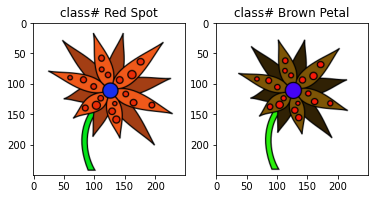

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.06226116725399189


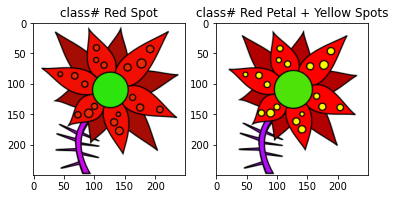

Rank: 2. Score: -0.06297636908137094


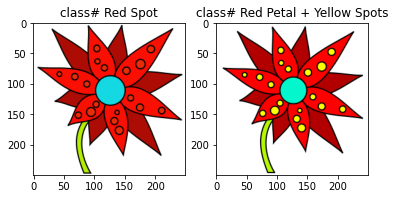

Rank: 3. Score: -0.06348919021587718


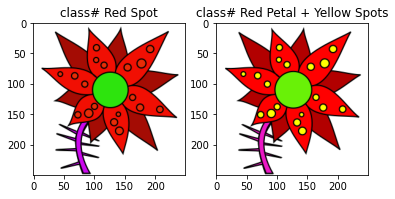

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.03702473384985039


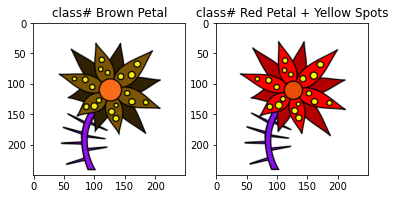

Rank: 2. Score: -0.03736696314307497


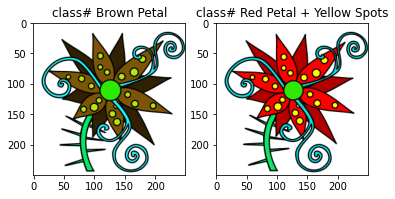

Rank: 3. Score: -0.037559806894714054


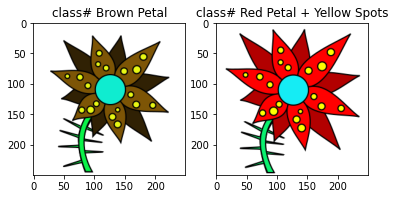

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 0.8821231443984272


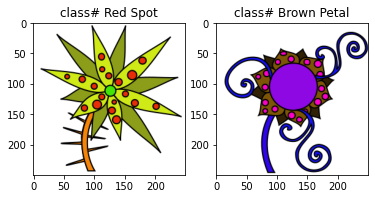

Rank: 2. Score: 0.8690257854461042


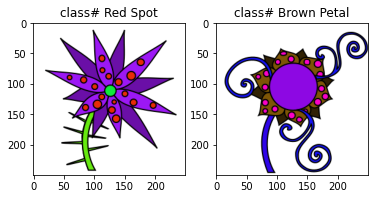

Rank: 3. Score: 0.8574209299136101


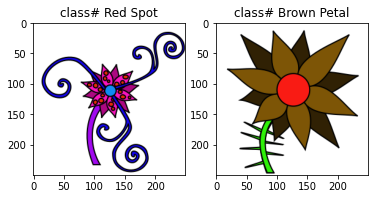

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.8621801854036927


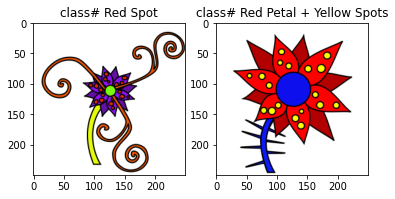

Rank: 2. Score: 0.8549560225461067


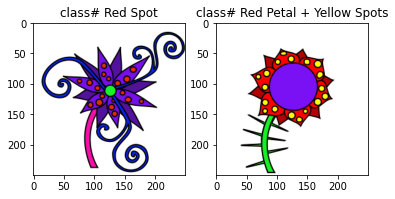

Rank: 3. Score: 0.8518275350156358


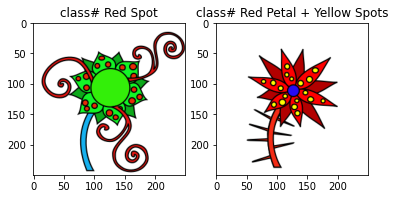

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.8585852592568004


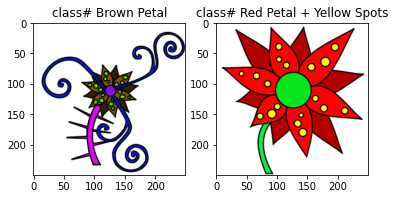

Rank: 2. Score: 0.8508671787477001


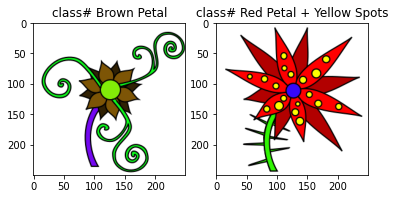

Rank: 3. Score: 0.8495412381980253


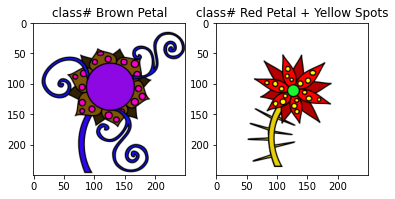

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 0.0


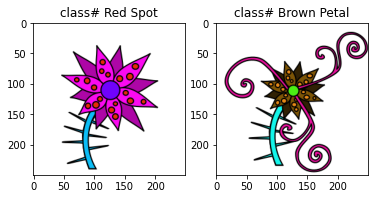

Rank: 2. Score: 0.0


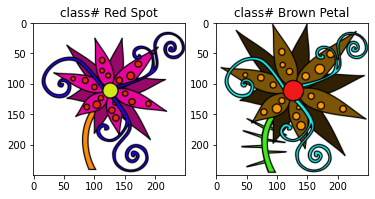

Rank: 3. Score: 0.0


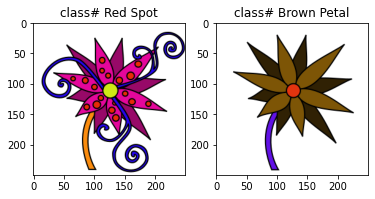

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.0


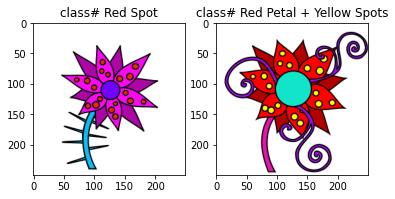

Rank: 2. Score: 0.0


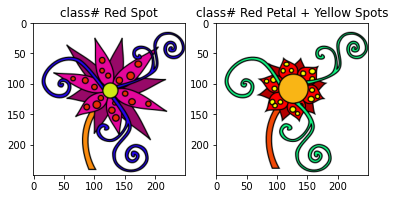

Rank: 3. Score: 0.0


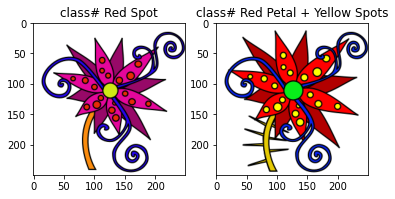

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.0


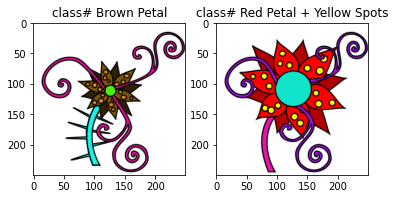

Rank: 2. Score: 0.0


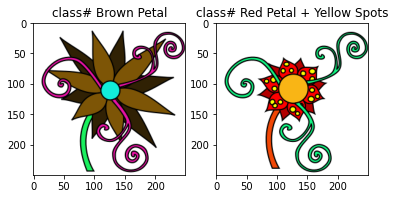

Rank: 3. Score: 0.0


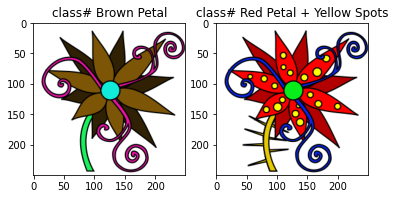

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: -0.0005214869941436717


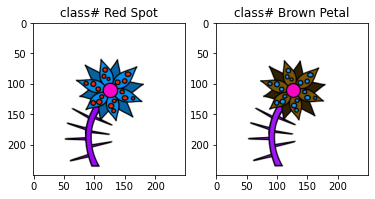

Rank: 2. Score: -0.0006654576742494145


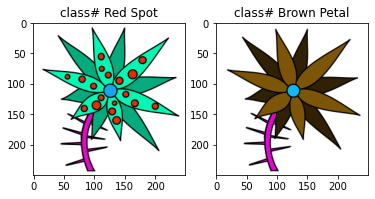

Rank: 3. Score: -0.0009373215494906662


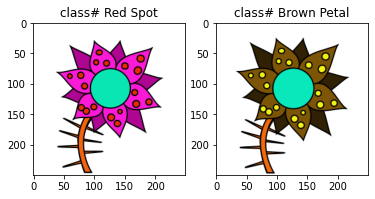

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.0012054169770177037


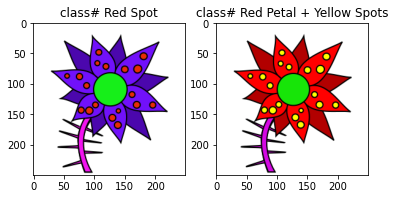

Rank: 2. Score: -0.0013613679816619761


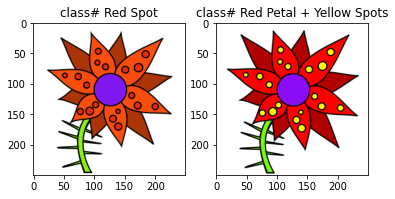

Rank: 3. Score: -0.0014269642832936968


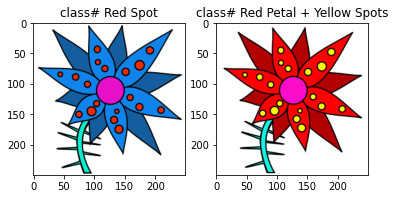

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: -0.0008407957161961077


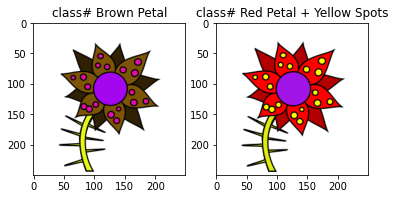

Rank: 2. Score: -0.0010833262340139704


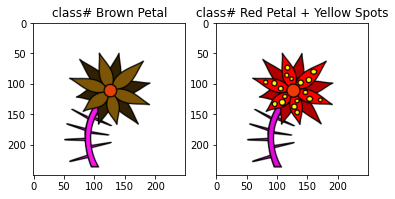

Rank: 3. Score: -0.0010908924087882355


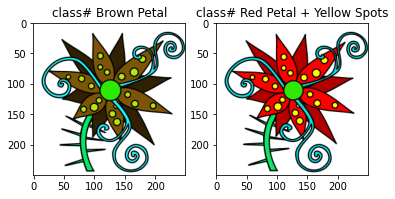

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 1.5301238928644838


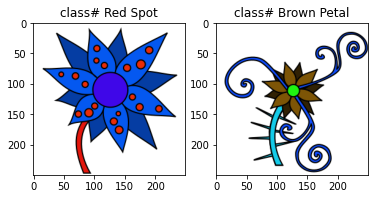

Rank: 2. Score: 1.523646817798655


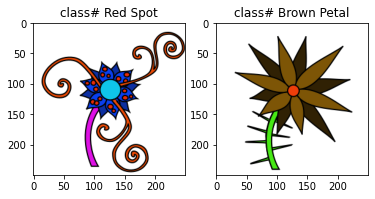

Rank: 3. Score: 1.515210585199053


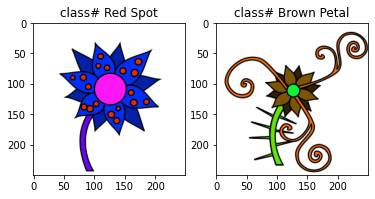

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 1.1207691268512532


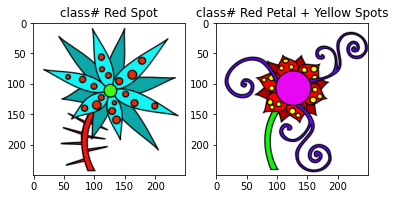

Rank: 2. Score: 1.1136448793499556


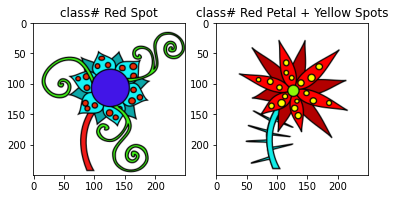

Rank: 3. Score: 1.1062599819450456


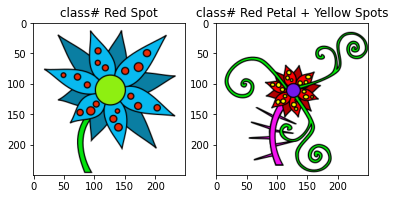

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 1.2724822452512137


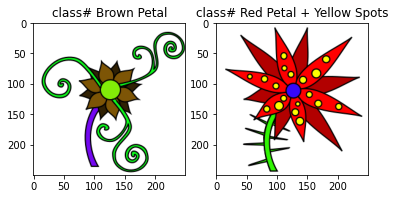

Rank: 2. Score: 1.2661252051381093


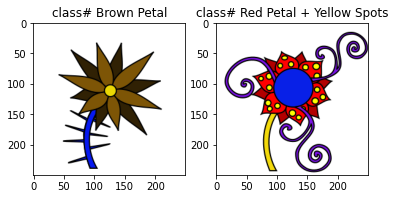

Rank: 3. Score: 1.2640287728866455


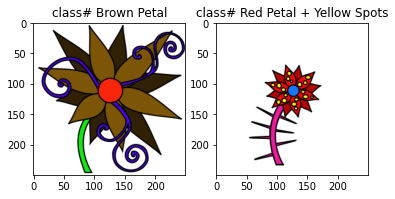

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 0.7397994734964934


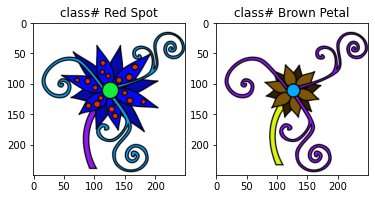

Rank: 2. Score: 0.7397994734964934


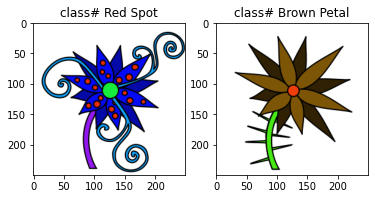

Rank: 3. Score: 0.7397994734964934


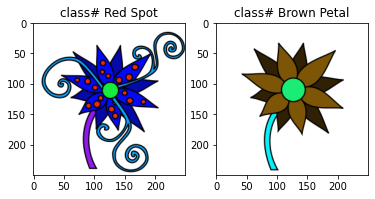

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.2946373059969607


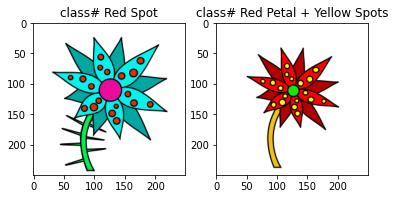

Rank: 2. Score: 0.2946373059969607


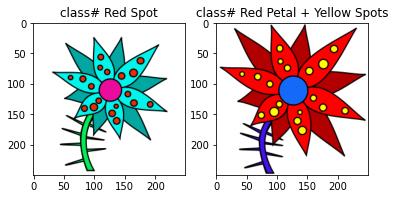

Rank: 3. Score: 0.2946373059969607


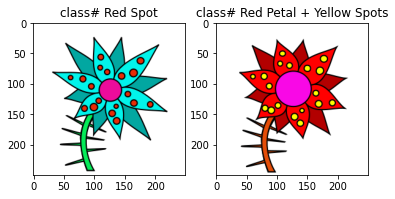

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.42161506650351344


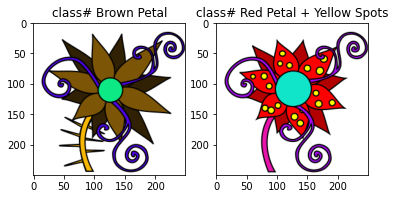

Rank: 2. Score: 0.42161506650351344


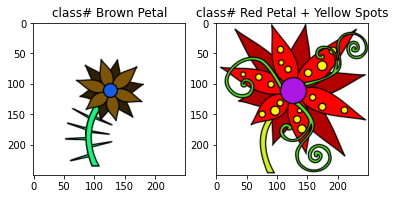

Rank: 3. Score: 0.42161506650351344


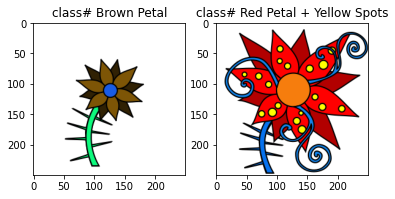

------------- Red Spot V.S. Brown Petal -------------
Rank: 1. Score: 0.7333759562618498


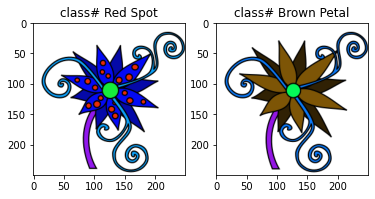

Rank: 2. Score: 0.7322212378972204


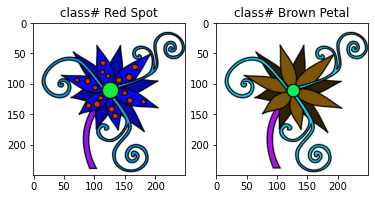

Rank: 3. Score: 0.7255383158291812


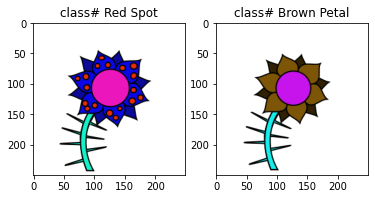

------------- Red Spot V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.2854374888483189


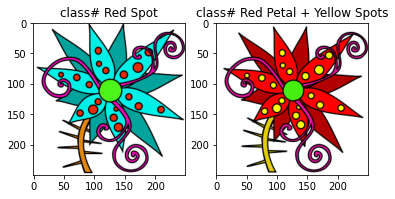

Rank: 2. Score: 0.28032863520131857


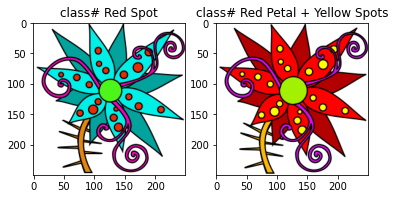

Rank: 3. Score: 0.2796018126913362


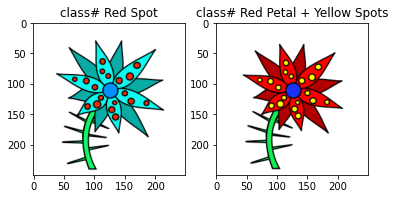

------------- Brown Petal V.S. Red Petal + Yellow Spots -------------
Rank: 1. Score: 0.42053174026949947


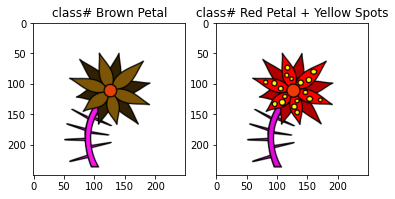

Rank: 2. Score: 0.4203398942732077


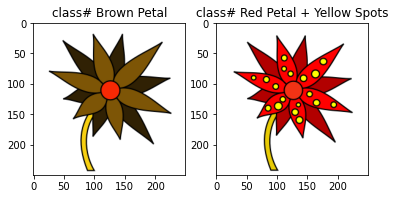

Rank: 3. Score: 0.420319851433965


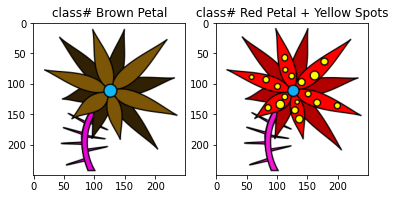

In [9]:
for alpha, beta in itertools.product([-1,0,1], [-1, 0, 1]):
    generate_pedagogic_pairs(
        "good", 
        alpha=alpha, 
        beta=beta, 
        #output_dir=f"experiment_200_data/treatment__alpha_{alpha}__beta_{beta}"
    )